In [1]:
import prometheus_pandas.ipython.magic
from prometheus_pandas import query
from matplotlib import pyplot as plt
import pandas as pd

In [31]:
#%%prometheus_query http://localhost:9090 
#    prom_histogram_bucket

In [3]:
p = query.Prometheus('http://localhost:9090')

In [32]:
p.query('prom_histogram_bucket')

prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="+Inf"}    4491.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="1"}        917.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="2"}       1781.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="3"}       2731.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="4"}       3606.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="5"}       4491.0
dtype: float64

In [11]:
res = p.query('increase(prom_histogram_bucket[1m])')
type(res)
print(res['{instance="host.docker.internal:9184",job="HistogramTest",le="5"}'])

120.00218185785197


In [24]:
foo = p.query('sum(increase(prom_histogram_bucket[1m])) by (le)')
foo

{le="+Inf"}    120.008728
{le="1"}        21.819769
{le="2"}        50.185468
{le="3"}        70.914248
{le="4"}        99.279948
{le="5"}       120.008728
dtype: float64

<Axes: >

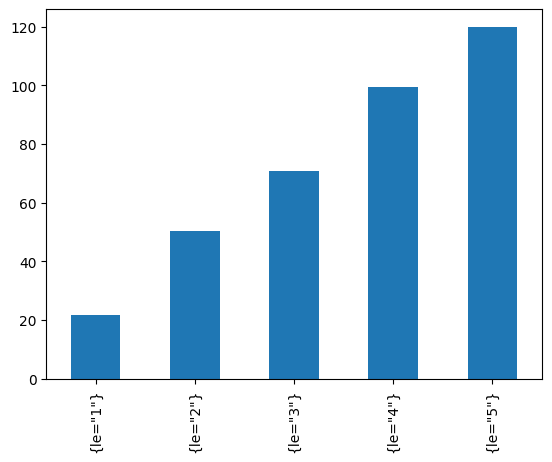

In [30]:
foo[1:].plot.bar()

In [26]:
p.query('histogram_quantile(0.95, increase(prom_histogram_bucket[1m]))') 

{}    4.710526
dtype: float64

In [27]:
p.query('histogram_quantile(0.95, sum(increase(prom_histogram_bucket[1m])) by (le))') 

{}    4.710526
dtype: float64

In [28]:
4.0 + 1.0 / (foo['{le="5"}'] - foo['{le="4"}']) * (foo['{le="5"}'] * 0.95 - foo['{le="4"}'])

4.7105263157894735

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


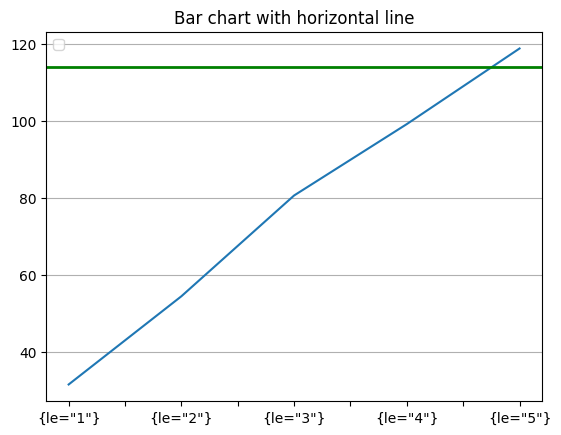

In [20]:
bar_plot = foo[1:].plot(kind='line', title = 'Bar chart with horizontal line');
bar_plot.legend(loc='upper left');
bar_plot.grid(axis='y');
#draw the line
bar_plot.axhline(y=0.95*120, color= 'red', linewidth=2,)

In [23]:
foo['{le="4"}']

96.00174548628158